In [1]:
import numpy as np
import pandas as pd

df=pd.read_csv('/Users/mh302/OneDrive - West Point/Backup/ORCEN/CPO/deep_learning/unique_cleaned_corr_data.csv')


In [2]:
# check for missing values
np.where(pd.isnull(df))

# drop rows with missing values
df.dropna()

,clean_text,y
0,eng checkout procedure req per tm 1 #### ### #...,1
1,moc check procedure new reinstall engine wp ##...,1
2,lmtf max pwr check require maintenance perform...,1
3,insp a### ## day flyable storage engine run du...,1
4,insp a### ## day flyable storage engine run du...,1
...,...,...
336843,bleed valve top hydraulic back pump module lea...,1
336844,2 fwd carog window panel warp frame replace wi...,1
336845,selector valve removal reinstall reqd troubles...,1
336846,jam nut power steering rod end apear loose alo...,1


In [3]:
# Check for empty strings
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [4]:
# Ensure that text variables are strings
df.clean_text = df.clean_text.astype(str)
df

,clean_text,y
0,eng checkout procedure req per tm 1 #### ### #...,1
1,moc check procedure new reinstall engine wp ##...,1
2,lmtf max pwr check require maintenance perform...,1
3,insp a### ## day flyable storage engine run du...,1
4,insp a### ## day flyable storage engine run du...,1
...,...,...
336843,bleed valve top hydraulic back pump module lea...,1
336844,2 fwd carog window panel warp frame replace wi...,1
336845,selector valve removal reinstall reqd troubles...,1
336846,jam nut power steering rod end apear loose alo...,1


## Build the vocabulary

In [5]:
from keras.preprocessing import text
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(df.clean_text)

word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}

vocab_size = len(word2id) + 1
embed_size = 100

wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in df.clean_text]

print('Vocab Size:', vocab_size)
print('Vocab Sample:', list(word2id.items())[:10])

Using TensorFlow backend.


Vocab Size: 41403
Vocab Sample: [('due', 1), ('a', 2), ('insp', 3), ('complete', 4), ('hour', 5), ('1', 6), ('status', 7), ('x', 8), ('upgrade', 9), ('iaw', 10)]


## Build a skip-gram generator

In [6]:
from keras.preprocessing.sequence import skipgrams

# generate skipgrams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=6) for wid in wids]

# view sample skipgrams
pairs, labels = skip_grams[0][0], skip_grams[0][1] 
for i in range(10):
    print("{:s} ({:d}), {:s} ({:d})) -> {:d}".format(
    id2word[pairs[i][0]], pairs[i][0],
    id2word[pairs[i][1]], pairs[i][1],
    labels[i]))

table (1185), req (126)) -> 1
wp (32), speedometer (5728)) -> 0
1 (6), table (1185)) -> 1
tm (30), req (126)) -> 1
req (126), hardwear (5239)) -> 0
procedure (764), p (59)) -> 1
procedure (764), 1 (6)) -> 1
p (59), pda (15298)) -> 0
1 (6), tm (30)) -> 1
wp (32), hellhole (17063)) -> 0


## Build the skipgram model architecture

In [7]:
from keras.layers import Dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.models import Model

# build skipgram architecture
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform', input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size, embeddings_initializer='glorot_uniform', input_length=1))
context_model.add(Reshape((embed_size, )))
model_arch = Dot(axes=1)([word_model.output, context_model.output])
model_arch = Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid')(model_arch)
model = Model([word_model.input, context_model.input], model_arch)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

#view model summary
print(model.summary())

#visualize model structure
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg'))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       4140300     embedding_1_input[0][0]          
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       4140300     embedding_2_input[0][0]          
____________________________________________________________________________________________

## Train the model

In [8]:
# Run this in an ipython consol in the tensorflow_cpu env and it works...
# PLOT THE MODEL ARCHITECTURE
#from keras.utils import plot_model                                                                                    

#import pydotplus as pydot                                                                                             

#plot_model(model, to_file='skip_gram_graph.png')                                                                      


In [9]:
#check if there are any empty lists in skip_grams
all(i for v in skip_grams for i in v)
# return of False means there are empty lists....

False

In [10]:
type(skip_grams)

list

In [11]:
print(skip_grams[2052][1][0])
#for i, elem in enumerate(skip_grams[2050:2052]):
#    print(np.array(list(zip(*elem[0])), dtype='int32'))

0


In [12]:
# checkpoint
from keras.models import load_model

loss_list = []
n_epochs = []
for epoch in range(1,7):
    loss = 0
    n=0
    n_epochs.append(epoch)
    for i, elem in enumerate(skip_grams):
        n+=1
        if elem[0]:
            pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
            pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
            labels = np.array(elem[1], dtype='int32')
            X= [pair_first_elem, pair_second_elem]
            Y= labels
            if i % 10000 ==0:
                print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
            loss += model.train_on_batch(X,Y)
        
        else: 
            #print('element ', n, 'was empty')
            next
    print('Epoc:', epoch, 'Loss:', loss)
    loss_list.append(loss)
    model.save(paste("SkipGramWindow6_epoch", epoch, "_loss", loss, ".h5")))

Processed 0 (skip_first, skip_second, relevance) pairs


/Users/mh302/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Processed 30000 (skip_first, skip_second, relevance) pairs
Processed 40000 (skip_first, skip_second, relevance) pairs
Processed 50000 (skip_first, skip_second, relevance) pairs
Processed 60000 (skip_first, skip_second, relevance) pairs
Processed 70000 (skip_first, skip_second, relevance) pairs
Processed 80000 (skip_first, skip_second, relevance) pairs
Processed 90000 (skip_first, skip_second, relevance) pairs
Processed 100000 (skip_first, skip_second, relevance) pairs
Processed 110000 (skip_first, skip_second, relevance) pairs
Processed 120000 (skip_first, skip_second, relevance) pairs
Processed 130000 (skip_first, skip_second, relevance) pairs
Processed 140000 (skip_first, skip_second, relevance) pairs
Processed 150000 (skip_first, skip_second, relevance) pairs
Processed 160000 (skip_first, skip_second, relevance) pairs
Processed 170000 (skip_first, skip_second, releva

Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Processed 30000 (skip_first, skip_second, relevance) pairs
Processed 40000 (skip_first, skip_second, relevance) pairs
Processed 50000 (skip_first, skip_second, relevance) pairs
Processed 60000 (skip_first, skip_second, relevance) pairs
Processed 70000 (skip_first, skip_second, relevance) pairs
Processed 80000 (skip_first, skip_second, relevance) pairs
Processed 90000 (skip_first, skip_second, relevance) pairs
Processed 100000 (skip_first, skip_second, relevance) pairs
Processed 110000 (skip_first, skip_second, relevance) pairs
Processed 120000 (skip_first, skip_second, relevance) pairs
Processed 130000 (skip_first, skip_second, relevance) pairs
Processed 140000 (skip_first, skip_second, relevance) pairs
Processed 150000 (skip_first, skip_second, relevance) pairs
Processed 160000 (skip_first, skip_second, relevance) pairs
Processed 170000 (skip_first, skip_second, releva

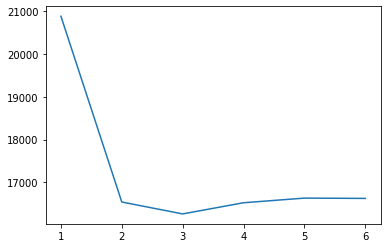

In [13]:
import matplotlib.pyplot as plt
print(plt.plot( n_epochs, loss_list))

## Get word embeddings

In [14]:
# load the model from the epoch I want
from keras.models import load_model
# creates a HDF5 file 
model = load_model('/Users/mh302/OneDrive - West Point/Backup/ORCEN/CPO/deep_learning/SkipGramWindow6-epoch3.h5')

/Users/mh302/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [15]:
word_embed_layer = model.layers[2]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
word_embeddings_df = pd.DataFrame(weights, index=id2word.values())
word_embeddings_df.head()

(41402, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
due,-0.629018,-0.834707,-0.036387,1.607567,-0.603658,0.920834,-0.804476,0.435626,-0.239946,0.084187,...,-0.631103,0.815686,1.653045,0.780842,0.638214,0.007144,-0.421967,1.758364,-0.251098,-0.103712
a,0.490344,0.825530,0.129828,1.192146,0.276918,2.568299,-1.591235,4.539120,-0.261595,1.036898,...,-0.051827,0.851402,1.102148,0.975293,0.541946,-0.023916,-0.409931,1.507721,-0.854454,-0.487539
insp,-0.010287,0.215249,0.583296,0.720521,-0.296515,2.380357,-0.303695,2.585713,-1.287044,-0.081138,...,-1.503917,2.577417,0.875972,0.104385,1.849434,0.780353,-1.050759,1.635484,-0.249013,0.334125
complete,-0.712770,0.358293,-0.686189,1.128047,-2.631917,-0.358828,-0.569536,-1.630976,-0.803602,0.316931,...,0.896975,-1.506647,2.104442,-0.093858,-0.050895,-0.075056,0.116491,0.134520,0.013105,-0.224933
hour,-0.177663,-0.489308,0.447907,0.362764,-1.624632,1.040519,2.062723,0.255518,0.855509,0.048299,...,-0.676630,0.283117,0.501608,0.483775,1.107908,-0.886637,1.656677,0.924225,-0.242616,-0.091458


In [21]:
# save the word embeddings
word_embeddings_df.to_csv('word_embeddings_wind6epoch3_df.csv', encoding='utf-8', index=True)

In [63]:
# save the model
# Save or load the model
#from keras.models import load_model
# creates a HDF5 file 
#model.save('/Users/mh302/OneDrive - West Point/Backup/ORCEN/CPO/deep_learning/skip_grm_model_window6epoch6.h5')

In [16]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx]
                              for idx in distance_matrix[word2id[search_term]-1].argsort()[1:10]+1]
                for search_term in ['cpc', 'inspection', 'debond']}
similar_words

(41402, 41402)


{'cpc': ['compound',
  'application',
  'touch',
  'angle',
  'applied',
  'follower',
  'transition',
  'proseale',
  'reapply'],
 'inspection': ['phase',
  'hr',
  'part',
  'reset',
  'final',
  'unit',
  'post',
  'cci',
  'initial'],
 'debond': ['erode',
  'clipping',
  'kevlar',
  'primere',
  'resin',
  'layer',
  'separation',
  'pitting',
  'leading']}

In [17]:
similar_words.items()

dict_items([('cpc', ['compound', 'application', 'touch', 'angle', 'applied', 'follower', 'transition', 'proseale', 'reapply']), ('inspection', ['phase', 'hr', 'part', 'reset', 'final', 'unit', 'post', 'cci', 'initial']), ('debond', ['erode', 'clipping', 'kevlar', 'primere', 'resin', 'layer', 'separation', 'pitting', 'leading'])])

In [19]:
import csv
w = csv.writer(open("/Users/mh302/OneDrive - West Point/Backup/ORCEN/CPO/deep_learning/similar_words_wind6ep3.csv", "w"))
for key, val in similar_words.items():
    w.writerow([key, val])

## Visualize word embedding space

Total words:  30 	Word Embedding Shapes:  (30, 100)


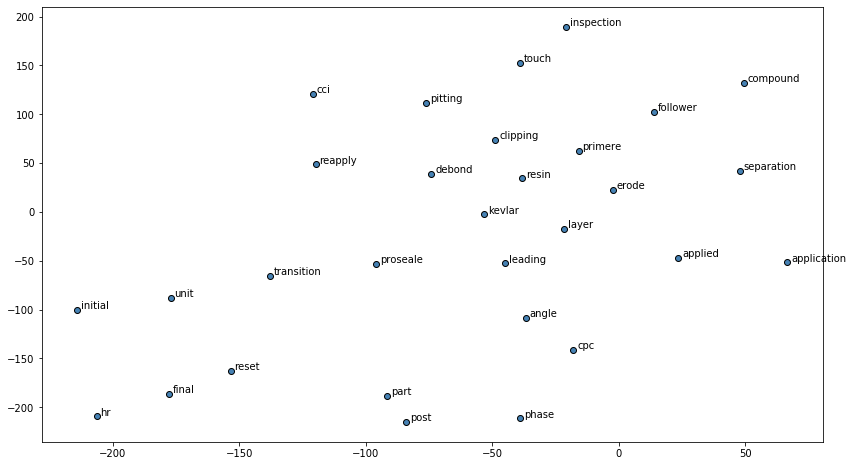

In [20]:
from sklearn.manifold import TSNE
#import matplotlib.pyplot as plt

words= sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words: ', len(words), '\tWord Embedding Shapes: ', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=7)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:,0], T[:, 1]):
    plt.annotate(label, xy=(x+1.5, y+1), xytext=(0,0), textcoords='offset points')
plt.savefig('tsne_embeddings_test_wind6ep6.png', dpi=300, bbox_inches='tight')
plt.show()

## Now use these embeddings as input to the deep learning with attention model

In [65]:
# load the model 
from keras.models import load_model
# creates a HDF5 file 
model = load_model('/Users/mh302/OneDrive - West Point/Backup/ORCEN/CPO/deep_learning/skip_grm_model_wind6ep6.h5')

/Users/mh302/opt/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [66]:
#get the word embeddings
word_embed_layer = model.layers[2]
weights = word_embed_layer.get_weights()[0][1:]

print(weights.shape)
word_embeddings_df = pd.DataFrame(weights, index=id2word.values())
word_embeddings_df.head()

(41402, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
due,0.109237,-1.318355,2.516291,-1.471483,0.206975,1.606868,0.628918,-0.889865,-3.352042,-1.067743,...,0.253509,0.443708,-0.412195,0.248245,-1.638613,-0.295509,-0.075639,-0.224759,0.163814,-2.894941
a,0.045899,0.123076,1.427140,-0.857554,0.517983,1.547075,0.977417,-0.941017,-4.371094,-0.196630,...,1.012220,0.510549,0.154836,-0.442095,-4.220841,0.889908,-0.228313,0.233876,0.387839,-0.980482
insp,-1.103153,-0.216018,0.925457,-1.105966,0.473906,0.373687,0.064506,-0.512718,-4.024156,-0.207517,...,0.387513,0.441416,-1.177999,-0.177475,-3.774897,0.046123,-0.968081,0.327105,1.109575,-2.033236
complete,-0.118405,-1.710485,3.908829,-0.997019,0.207554,0.974639,-0.064226,-0.587708,-3.207435,-0.348297,...,0.310184,0.540790,-1.873894,-0.682901,-0.310837,-1.285710,-0.517996,0.781343,0.090241,-3.060693
hour,1.614540,-0.520177,1.941359,-0.425241,2.525288,0.721534,0.148305,0.183733,-1.677056,-0.196120,...,-0.089746,0.465792,-1.242614,0.286452,-0.844060,-0.112564,-0.625619,1.684846,-0.015390,0.839209


# Find the 5 closest words to each corrosion search word

In [69]:
# Read in the corrosion search words 
import numpy as np
import pandas as pd

sw_df=pd.read_csv('/Users/mh302/OneDrive - West Point/Backup/ORCEN/CPO/deep_learning/LMI_Corrosion_search_words.csv')
sw_df.head()

,New_WordOrder,WordOrder,MaintOperationKeyword,UpdateWord,CorroPerc,SearchWord,NOT Like SearchWord,Type,Length,Priority,Review,rfs_review,Prev/Corro,LMIWBS
0,1.0,283.0,AGE HARDEN,Flame,100%,"""Flame harden*""",NaN,Contains,15.0,1.0,Yes,Yes,1.0,1.0
1,2.0,251.0,AGE HARDEN,Heat treat,100%,"""HEATTREATMENT""",NaN,Contains,15.0,1.0,No,No,1.0,1.0
2,3.0,373.0,AGE HARDEN,Flame,100%,"""Flame harden""",NaN,Contains,14.0,1.0,Yes,Yes,1.0,1.0
3,4.0,376.0,AGE HARDEN,Flame,100%,"""Flame spray*""",NaN,Contains,14.0,1.0,Yes,Yes,1.0,1.0
4,5.0,426.0,AGE HARDEN,Case Harden,100%,"""Caseharden*""",NaN,Contains,13.0,1.0,No,No,1.0,1.0


In [71]:
# preprocess them with the same preprocessing steps from UNIQUE_TEXT_ATTN_MDL_92%ACC
# At least to lower, remove special characters, remove numbers
sw_list = sw_df.SearchWord.values
sw_list[0:5]


array(['"Flame harden*"', '"HEATTREATMENT"', '"Flame harden"',
       '"Flame spray*"', '"Caseharden*"'], dtype=object)

In [76]:
# # Removing Special Characters function
import re
def remove_special_characters(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    return text

In [73]:
# remove numbers function
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x


In [79]:
cleaned_sw_list = []
for item in sw_list:
    item = str(item)
    items = str(item.split()) # split into individual words by spaces
    out_strings = []
    for word in items:
        word.lower() # make caps to lower
        no_spec_chars = remove_special_characters(word)
        no_nums = clean_numbers(no_spec_chars)
        out_strings.append(no_nums)
    combined = " ".join(out_strings) # recombine words into string
    cleaned_sw_list.append(combined)

In [88]:
cleaned_sw_list = []
for words in sw_list:
    words = str(words)
    words = words.lower() # make caps to lower
    no_spec_chars = remove_special_characters(words)
    no_nums = clean_numbers(no_spec_chars)
    if "and not" in no_nums:
        trunc_indx = no_nums.find("and not") # returns the start index of "and not"
        # slice off the text from "and not" to the end
        no_nums = no_nums[0:trunc_indx]
    cleaned_sw_list.append(no_nums)

In [164]:
# print the processed search words
cleaned_sw_list

# write this list to a text file
#with open("cleaned_sw_list.txt", "w") as output:
    #output.write(str(cleaned_sw_list))
    
# write to txt without quotes or spaces
with open("cleaned_sw.txt", "a+") as myfile:
    myfile.write(",".join(map(str, cleaned_sw_list))+"\n")

## find similar words to the search words

In [99]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_search_words = {search_term: [id2word[idx]
                              for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1]
                for search_term in cleaned_sw_list if search_term in word2id.keys()}
similar_search_words
# this dictionary maps the LMI search term to the similar words from the skip_gram_model

(41402, 41402)


{'hardener': ['stabilizatn',
  'ibet',
  'mrke',
  'fabricatedshorted',
  'completepaint'],
 'hardness': ['parked', 'blanet', 'noticeably', 'damagesoundproofe', 'lbds'],
 'preheat': ['hvms', 'fuelfrombnut', 'meaurement', 'illistration', 'satcon'],
 'debounding': ['intalled', 'repairment', 'visualy', 'jung', 'turntable'],
 'disbonding': ['cloth', 'layer', '3na', 'resin', 'errosion'],
 'disponding': ['defeere', 'hdfs', 'tb2a', 'fcrmma', 'update2'],
 'debonding': ['layer', 'lip', 'disbonding', 'kevlar', 'leading'],
 'disbonded': ['disponde', 'abrasive', 'disbond', 'cloth', '3na'],
 'debonded': ['4t', 'inspectionblue', 'mtpp', 'securinig', 'weatherproof'],
 'debound': ['olsen', 'darla', 'ripps', 'dshrd', 'preforme'],
 'disbond': ['abrasive',
  'penetrate',
  'delaminating',
  'anhedral',
  'delaminated'],
 'debond': ['region', 'nickle', 'erode', 'blending', 'meob'],
 'debonde': ['rebonde', 'deteriorate', 'nutplate', 'chafe', 'marked'],
 'baterie': ['replac', 'sfa', 'u2', 'seviceability', '

In [102]:
# write dict to csv
import csv

w = csv.writer(open("/Users/mh302/OneDrive - West Point/Backup/ORCEN/CPO/deep_learning/LMI_sw_to_similar_wd_dict_wind6ep6.csv", "w"))
for key, val in similar_search_words.items():
    w.writerow([key, val])

## Return the words that are not included in the current search word bank

In [133]:
proposed_new_sws = {}
for key, words in similar_search_words.items(): 
    for word in words:
        if word not in cleaned_sw_list:
            if key in proposed_new_sws.keys():
            # append the new number to the existing array at this slot
                proposed_new_sws[key].append(word)
            else:
                # create a new array in this slot
                proposed_new_sws[key] = [word]

In [134]:
proposed_new_sws

{'hardener': ['stabilizatn',
  'ibet',
  'mrke',
  'fabricatedshorted',
  'completepaint'],
 'hardness': ['parked', 'blanet', 'noticeably', 'damagesoundproofe', 'lbds'],
 'preheat': ['hvms', 'fuelfrombnut', 'meaurement', 'illistration', 'satcon'],
 'debounding': ['intalled', 'repairment', 'visualy', 'jung', 'turntable'],
 'disbonding': ['cloth', 'layer', '3na', 'errosion'],
 'disponding': ['defeere', 'hdfs', 'tb2a', 'fcrmma', 'update2'],
 'debonding': ['layer', 'lip', 'kevlar', 'leading'],
 'disbonded': ['disponde', 'cloth', '3na'],
 'debonded': ['4t', 'inspectionblue', 'mtpp', 'securinig', 'weatherproof'],
 'debound': ['olsen', 'darla', 'ripps', 'dshrd', 'preforme'],
 'disbond': ['penetrate', 'delaminating', 'anhedral', 'delaminated'],
 'debond': ['region', 'erode', 'blending', 'meob'],
 'debonde': ['rebonde', 'deteriorate', 'nutplate', 'chafe', 'marked'],
 'baterie': ['replac', 'sfa', 'u2', 'seviceability', 'usual'],
 'ndi': ['qty', '1ea', 'rl', 'pit', 'mike'],
 'ndt': ['penetrate', 

In [136]:
# This is the dictionary (as csv) of proposed new search words (the values) for each existing LMI search word (the keys)
w = csv.writer(open("/Users/mh302/OneDrive - West Point/Backup/ORCEN/CPO/deep_learning/proposed_new_sws_dict_wind6ep6.csv", "w"))
for key, val in proposed_new_sws.items():
    w.writerow([key, val])